In [33]:
from glob import glob
import pandas as pd 
import spacy
from spacy_transformers import Transformer
from nltk import sent_tokenize
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

### Extract dialogue scripts from the Naruto subtitle files for each episode. 

In [2]:
from glob import glob
import os

file_paths = sorted(glob("C:/Users/Wen/OneDrive/Documents/GitHub/Portfolio_Project/Deep Learning/Shinobi Naruto Insights -NLP/data/Naruto Complete Subtitles Series/*.ass"))

scripts = []
number_episodes = []

for path in file_paths:
    try:
        with open(path, "r") as file:
            lines = file.readlines()
            lines = lines[27:]
            rows = [",".join(line.split(",")[9:]) for line in lines if line.startswith('Dialogue:')]
            rows = [line.replace("\\N", " ") for line in rows]
            script = " ".join(rows)
            episode = int(os.path.basename(path).split("-")[1].split(".")[0].strip())
            scripts.append(script)
            number_episodes.append(episode)
    except Exception as e:
        print(f"Failed to process {path}: {str(e)}")

for script, episode in zip(scripts, number_episodes):
    print(f"Episode {episode}: {script[:100]}...")  # Print first 100 characters of each script


Episode 1: A long time ago, a powerful demon fox appeared with nine tails.
 With its powerful tails,
 it could ...
Episode 2: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 3: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 4: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 5: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 6: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 7: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 8: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside my heart is pounding
 My throat ...
Episode 9: C'mon!
 Running like a fugitive,
 Being chased by something
 Inside m

In [3]:
df = pd.DataFrame.from_dict({'Episodes': number_episodes, "script":scripts})
df.head()

,Episodes,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


### NLP Model 

In [27]:
!python -m spacy download en_core_web_trf


     ---------------------------------------- 0.0/457.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/457.4 MB ? eta -:--:--
     -------------------------------------- 0.0/457.4 MB 435.7 kB/s eta 0:17:30
     -------------------------------------- 0.1/457.4 MB 653.6 kB/s eta 0:11:40
     ---------------------------------------- 0.3/457.4 MB 1.7 MB/s eta 0:04:23
     ---------------------------------------- 0.8/457.4 MB 4.0 MB/s eta 0:01:54
     ---------------------------------------- 1.9/457.4 MB 8.2 MB/s eta 0:00:56
     --------------------------------------- 3.4/457.4 MB 11.3 MB/s eta 0:00:41
     --------------------------------------- 4.8/457.4 MB 14.1 MB/s eta 0:00:33
      -------------------------------------- 6.1/457.4 MB 16.3 MB/s eta 0:00:28
      -------------------------------------- 8.4/457.4 MB 19.1 MB/s eta 0:00:24
      ------------------------------------- 10.1/457.4 MB 20.9 MB/s eta 0:00:22
     - ------------------------------------ 12.2/457.4

Using a DataFrame to organize the script data by episodes and applying a function "get_ners" to extract named entities recognized as "PERSON" from each script. 

Extracting only first name of each character. 

In [12]:
nlp = spacy.load('en_core_web_trf')

def get_ners(script):
    script_sentences = sent_tokenize(script)
    ner_output = []
    
    for sentence in script_sentences: 
        doc = nlp(sentence)
        ners = set()
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                full_name = ent.text
                first_name = full_name.split(" ")[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output
                
df = pd.DataFrame.from_dict({'Episodes': number_episodes, "script": scripts})
df['ners'] = df['script'].apply(get_ners)
df.head()


,Episodes,script,ners
0,1,"A long time ago, a powerful demon fox appeared...","[[], [], [], [], [], [], [], [Naruto], [], [],..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas...","[[], [], [], [], [], [], [], [], [], [Konohama..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas...","[[], [], [], [Sakura, Sasuke], [], [Konohamaru..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas...","[[], [], [], [Naruto], [], [], [Iruka], [], [N..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas...","[[], [], [], [], [], [], [], [], [], [], [], [..."


In [13]:
window_size = 10 
character_relationships = []

for episode_entities in df["ners"]:
    windowed_entities = []
    
    for sentence_entities in episode_entities:
        windowed_entities.append(sentence_entities)
        windowed_entities = windowed_entities[-window_size:]
        
        entities_in_window = sum(windowed_entities, [])
        
        for current_entity in sentence_entities:
            for entity_in_window in entities_in_window:
                if current_entity != entity_in_window:
                    
                    sorted_relationship = sorted([current_entity, entity_in_window])
                    character_relationships.append(sorted_relationship)

In [52]:
relationship_data = pd.DataFrame({"value": character_relationships})

relationship_data["source"] = relationship_data["value"].apply(lambda x: x[0])
relationship_data["target"] = relationship_data["value"].apply(lambda x: x[1])

relationship_data = relationship_data.groupby(['source','target']).count().reset_index()


relationship_data = relationship_data.sort_values('value',ascending=False)
relationship_data.head()


,source,target,value
2577,Naruto,Sasuke,847
2975,Sakura,Sasuke,438
2570,Naruto,Sakura,367
1363,Hinata,Naruto,324
2809,Orochimaru,Sasuke,274


In [74]:
relationship_data = relationship_data.head(250)

In [75]:
character_network = nx.from_pandas_edgelist(relationship_data, 
                                            source = "source",
                                            target = "target",
                                            edge_attr= "value",
                                            create_using = nx.Graph())


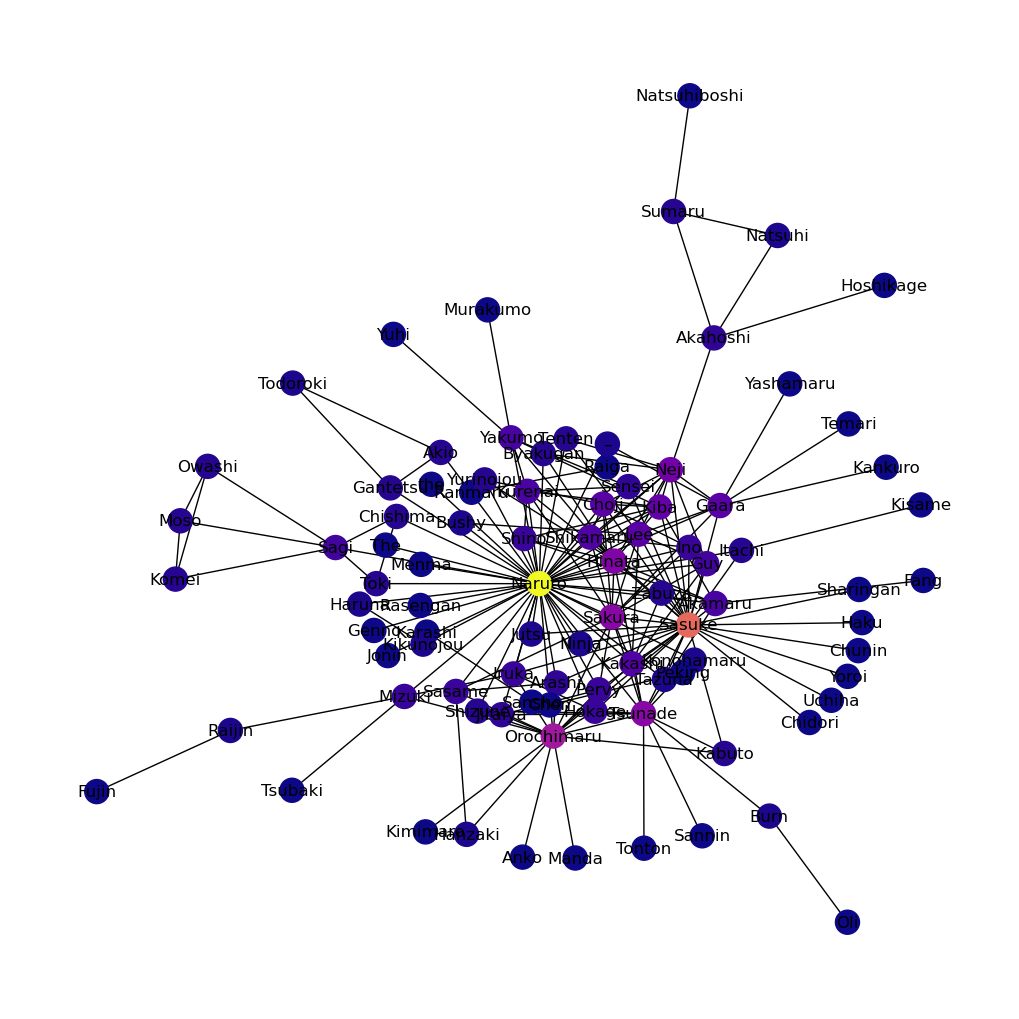

In [76]:
degrees = nx.degree(character_network)
degree_values = [degree for node, degree in degrees]

max_degree = max(degree_values)
min_degree = min(degree_values)
norm_degrees = [(degree - min_degree) / (max_degree - min_degree) for degree in degree_values]

node_colors = plt.cm.plasma(norm_degrees) 

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(character_network)
nx.draw(character_network, pos, with_labels=True, node_color=node_colors, edge_cmap=plt.cm.Blues)
plt.show()


In [81]:
net = Network(notebook=True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(character_network.degree)
nx.set_node_attributes(character_network, node_degree, 'size')

for edge in character_network.edges():
    net.add_edge(edge[0], edge[1])

net.barnes_hut()

net.show("naruto_network.html")


naruto_network.html
